In [17]:
channels = ['b', 'g', 'r']# since opencv reads img as BGR channel order
for i, channel in enumerate(channels):
    # Calculating Histogram of each channel.
    histogram = cv.calcHist([img], [i], None, [256], [0,256])

equalized_channels = []
for channel in cv.split(img0):
    # Each channel must be equalized seperately.
    equalized_channels.append(cv.equalizeHist(channel)) 
equalized_img = cv.merge(equalized_channels)    

In [4]:
a, b = [40,200]
# Declaring tranformations for each region
tr1 = np.linspace(0,a,93).astype('uint8')
tr2 = np.linspace(a+1,b,30).astype('uint8')
tr3 = np.linspace(b+1,255,133).astype('uint8')
# Concatenating above tran: func: to get one transformation
transf = np.concatenate((tr1, tr2), axis = 0)
transf = np.concatenate((transf, tr3), axis = 0)
# Apply Transformation
transformed_img = cv.LUT(img, transf)

In [5]:
def gammacorrect(image, gammaval):
    # Calculating the lookup table for a given gamma value.
    table = np.array([(i/255.0)**(gamma)*255.0 for i in np.arange(0,256)]).astype('uint8')
    img_gamma = cv.LUT(image, table)
    return img_gamma

In [6]:
def gaussianSmooth(image, kernelSize, sigma):
    max_abs = np.floor(kernelSize/2) # If kernelSize = 11
    x_range = np.arange(-max_abs,max_abs +1,1) #(from -5 to +5 range)
    y_range = np.arange(-max_abs,max_abs +1,1) #(from -5 to +5 range)
    X,Y = np.meshgrid(x_range, y_range)
    # Bulding Gaussian kernel using the function
    kernel = np.exp((-(X**2 + Y**2))/(2*sigma**2))/(2*np.pi*sigma**2)
    # Convolution of the image with the kernel
    smoothed_img = cv.filter2D(image,-1,kernel)
    return smoothed_img

In [7]:
sigma = 2 
kernel = cv.getGaussianKernel(5, sigma) #create the gaussian kernel
blurred = cv.sepFilter2D(img, -1, kernel, kernel, anchor=(-1,-1), delta=0, borderType=cv.BORDER_REPLICATE)
mask = img.astype('float32') - blurred.astype('float32')
k = 1 # when k =1 : unsharp masking, when k>1 : Highboost Filtering
sharpened = cv.addWeighted(img.astype('float32') , 1., mask, k, 0)

In [ ]:
# noise generated using noisy function avalable at
# Source: https://stackoverflow.com/a/30609854
saltpepper = noisy("s&p", img)
kernelSize = 3
medianfiltered_image = cv.medianBlur(saltpepper, kernelSize) 

In [10]:
gaussianB = cv.GaussianBlur(img, (9,9) ,6,6) #sigmaX,sigmaY = 6
#dst = cv.bilateralFilter(src, d, sigmaColor, sigmaSpace)
bilateral1 = cv.bilateralFilter(img,9,100,6) 
bilateral2 = cv.bilateralFilter(img,13,10,6) 

100


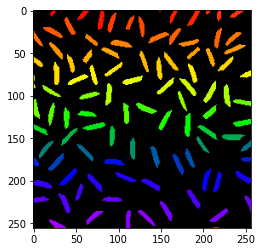

In [19]:
# reading the image as an eight bit grayscale image
img = cv.imread("../a01images/rice.png", cv.IMREAD_GRAYSCALE)

# adaptive thresholding due to non uniform illumination in the image
kernelSize, C = 25,-10
img_adapt_thresh = th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,kernelSize, C)
# Morphological transformation:  Erosion
# to eliminate white noise and detach connected objects
ksize = 3
kernel = cv.getStructuringElement(cv.MORPH_RECT,(ksize,ksize))
eroded_img = cv.erode(img_adapt_thresh, kernel)

#-----------------Connected components Analysis(CCA)----------------------
num_labels, labeledImg = cv.connectedComponents(eroded_img)
# Background is considered as another object in CCA.
# Therfore it needs to be subtracted to get the grain count
num_grains = num_labels -1; print(num_grains)

#-----------------Show components using a color Map.----------------------
# find min and max pixel values and their locations the image.
(minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(labeledImg)
# Normalize the image so the min value is 0 and max value is 255.
labeledImg = (255/(maxVal-minVal)) * (labeledImg - minVal)
# Applying the color map for better visulization
imgColorMap = cv.applyColorMap(labeledImg.astype('uint8'), cv.COLORMAP_RAINBOW)
# Making the background black
imgColorMap[labeledImg==0] = 0
# Display colormapped labels
plt.imshow(imgColorMap[:,:,::-1])

In [12]:
def zoom(image, scaling_factor, method):
    img = image
    sf = scaling_factor
    # Determining dimensions of the zoomed image
    if len(img.shape) == 2: # for GRAYSCALE images
        zoomedImgDims = [int(dim*sf) for dim in img.shape]
    else: # for COLOR images
        zoomedImgDims = [int(dim*sf) for dim in img.shape]
        zoomedImgDims[2] = 3
    # declaring an empty array to store values
    zoomedImg = np.zeros(zoomedImgDims, dtype = img.dtype)
#====================Nearest Neighbour Mehtod(NNM)=========================
    if method == 'nn':        
        for row in range(zoomedImg.shape[0]):
            # Calculating corresponding pixels in original image 
            source_row = round(row/sf)
            # Overflow handling
            if source_row > img.shape[0]-1: source_row = img.shape[0]-1
            for column in range(zoomedImg.shape[1]):
                # Calculating corresponding pixels in original image        
                source_column = round(column/sf)
                # Overflow handling
                if source_column > img.shape[1]-1: source_column = img.shape[1]-1
                # Assigning pixel values
                if len(img.shape) == 2:
                    zoomedImg[row][column] = img[source_row][source_column]
                else:
                    for channel in range(3):
                        zoomedImg[row][column][channel] = \
                                            img[source_row][source_column][channel]
#======================Bilinear Interpolation Mehtod(BIM)==================     
    if method == 'bi':
        for row in range(zoomedImg.shape[0]):
            # Calculating corresponding row in original image
            row_position = row/sf
            row_below = int(np.floor(row_position))
            row_up = int(np.ceil(row_position))
            if row_up > img.shape[0]-1: row_up = img.shape[0]-1
            for column in range(zoomedImg.shape[1]):
                # Calculating corresponding column in original image       
                column_position = column/sf
                column_previous = int(np.floor(column_position))
                column_next = int(np.ceil(column_position))
                if column_next > img.shape[1]-1: column_next = img.shape[1]-1

                diff1 = row_position - row_below 
                diff2 = column_position - column_previous
                if len(img.shape) == 2: # for GRAYSCALE images
                    interVal1 = img[row_below][column_previous]*(1-diff1)\
                                + img[row_up][column_previous]*(diff1)
                    interVal2 = img[row_below][column_next]*(1-diff1)\
                                + img[row_up][column_next]*(diff1)
                    zoomedImg[row][column] = (interVal1*(1-diff2)\
                                              + interVal2*(diff2)).astype('uint8')
                else: # for COLOR images
                    for channel in range(3):
                        interVal1 = img[row_below][column_previous][channel]*(1-diff1)\
                                + img[row_up][column_previous][channel]*(diff1)
                        interVal2 = img[row_below][column_next][channel]*(1-diff1)\
                                + img[row_up][column_next][channel]*(diff1)
                        zoomedImg[row][column][channel] = (interVal1*(1-diff2)\
                                                           + interVal2*(diff2)).astype('uint8')
    return zoomedImg